In [2]:
using Revise
using QuantumCollocation
using NamedTrajectories
using LinearAlgebra
using SparseArrays
using Random; Random.seed!(123);

# Transmon System

Let's build a system describing mulitlevel transmon with Hamiltonian

$$
H(t) = -\frac{\delta}{2} a^\dagger a^\dagger a a + u_1(t) (a + a^\dagger) + u_2(t) i (a - a^\dagger)
$$

This system is implemented via the `TransmonSystem` constructor in `quantum_system_templates.jl`.

In [3]:
sys = TransmonSystem(levels=4, ω=5.1, δ=0.19)

op = EmbeddedOperator(:X, sys)

op.operator |> sparse

4×4 SparseMatrixCSC{ComplexF64, Int64} with 2 stored entries:
     ⋅      1.0+0.0im      ⋅          ⋅    
 1.0+0.0im      ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    

In [4]:
T = 100
dt = 0.1

prob = UnitarySmoothPulseProblem(sys, op, T, dt; 
    a_bound=0.1
)

solve!(prob; max_iter=100)

println("fidelity = ", unitary_fidelity(prob, subspace=op.subspace_indices)^2)

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    52194
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    22056

Total number of variables............................:     3864
           

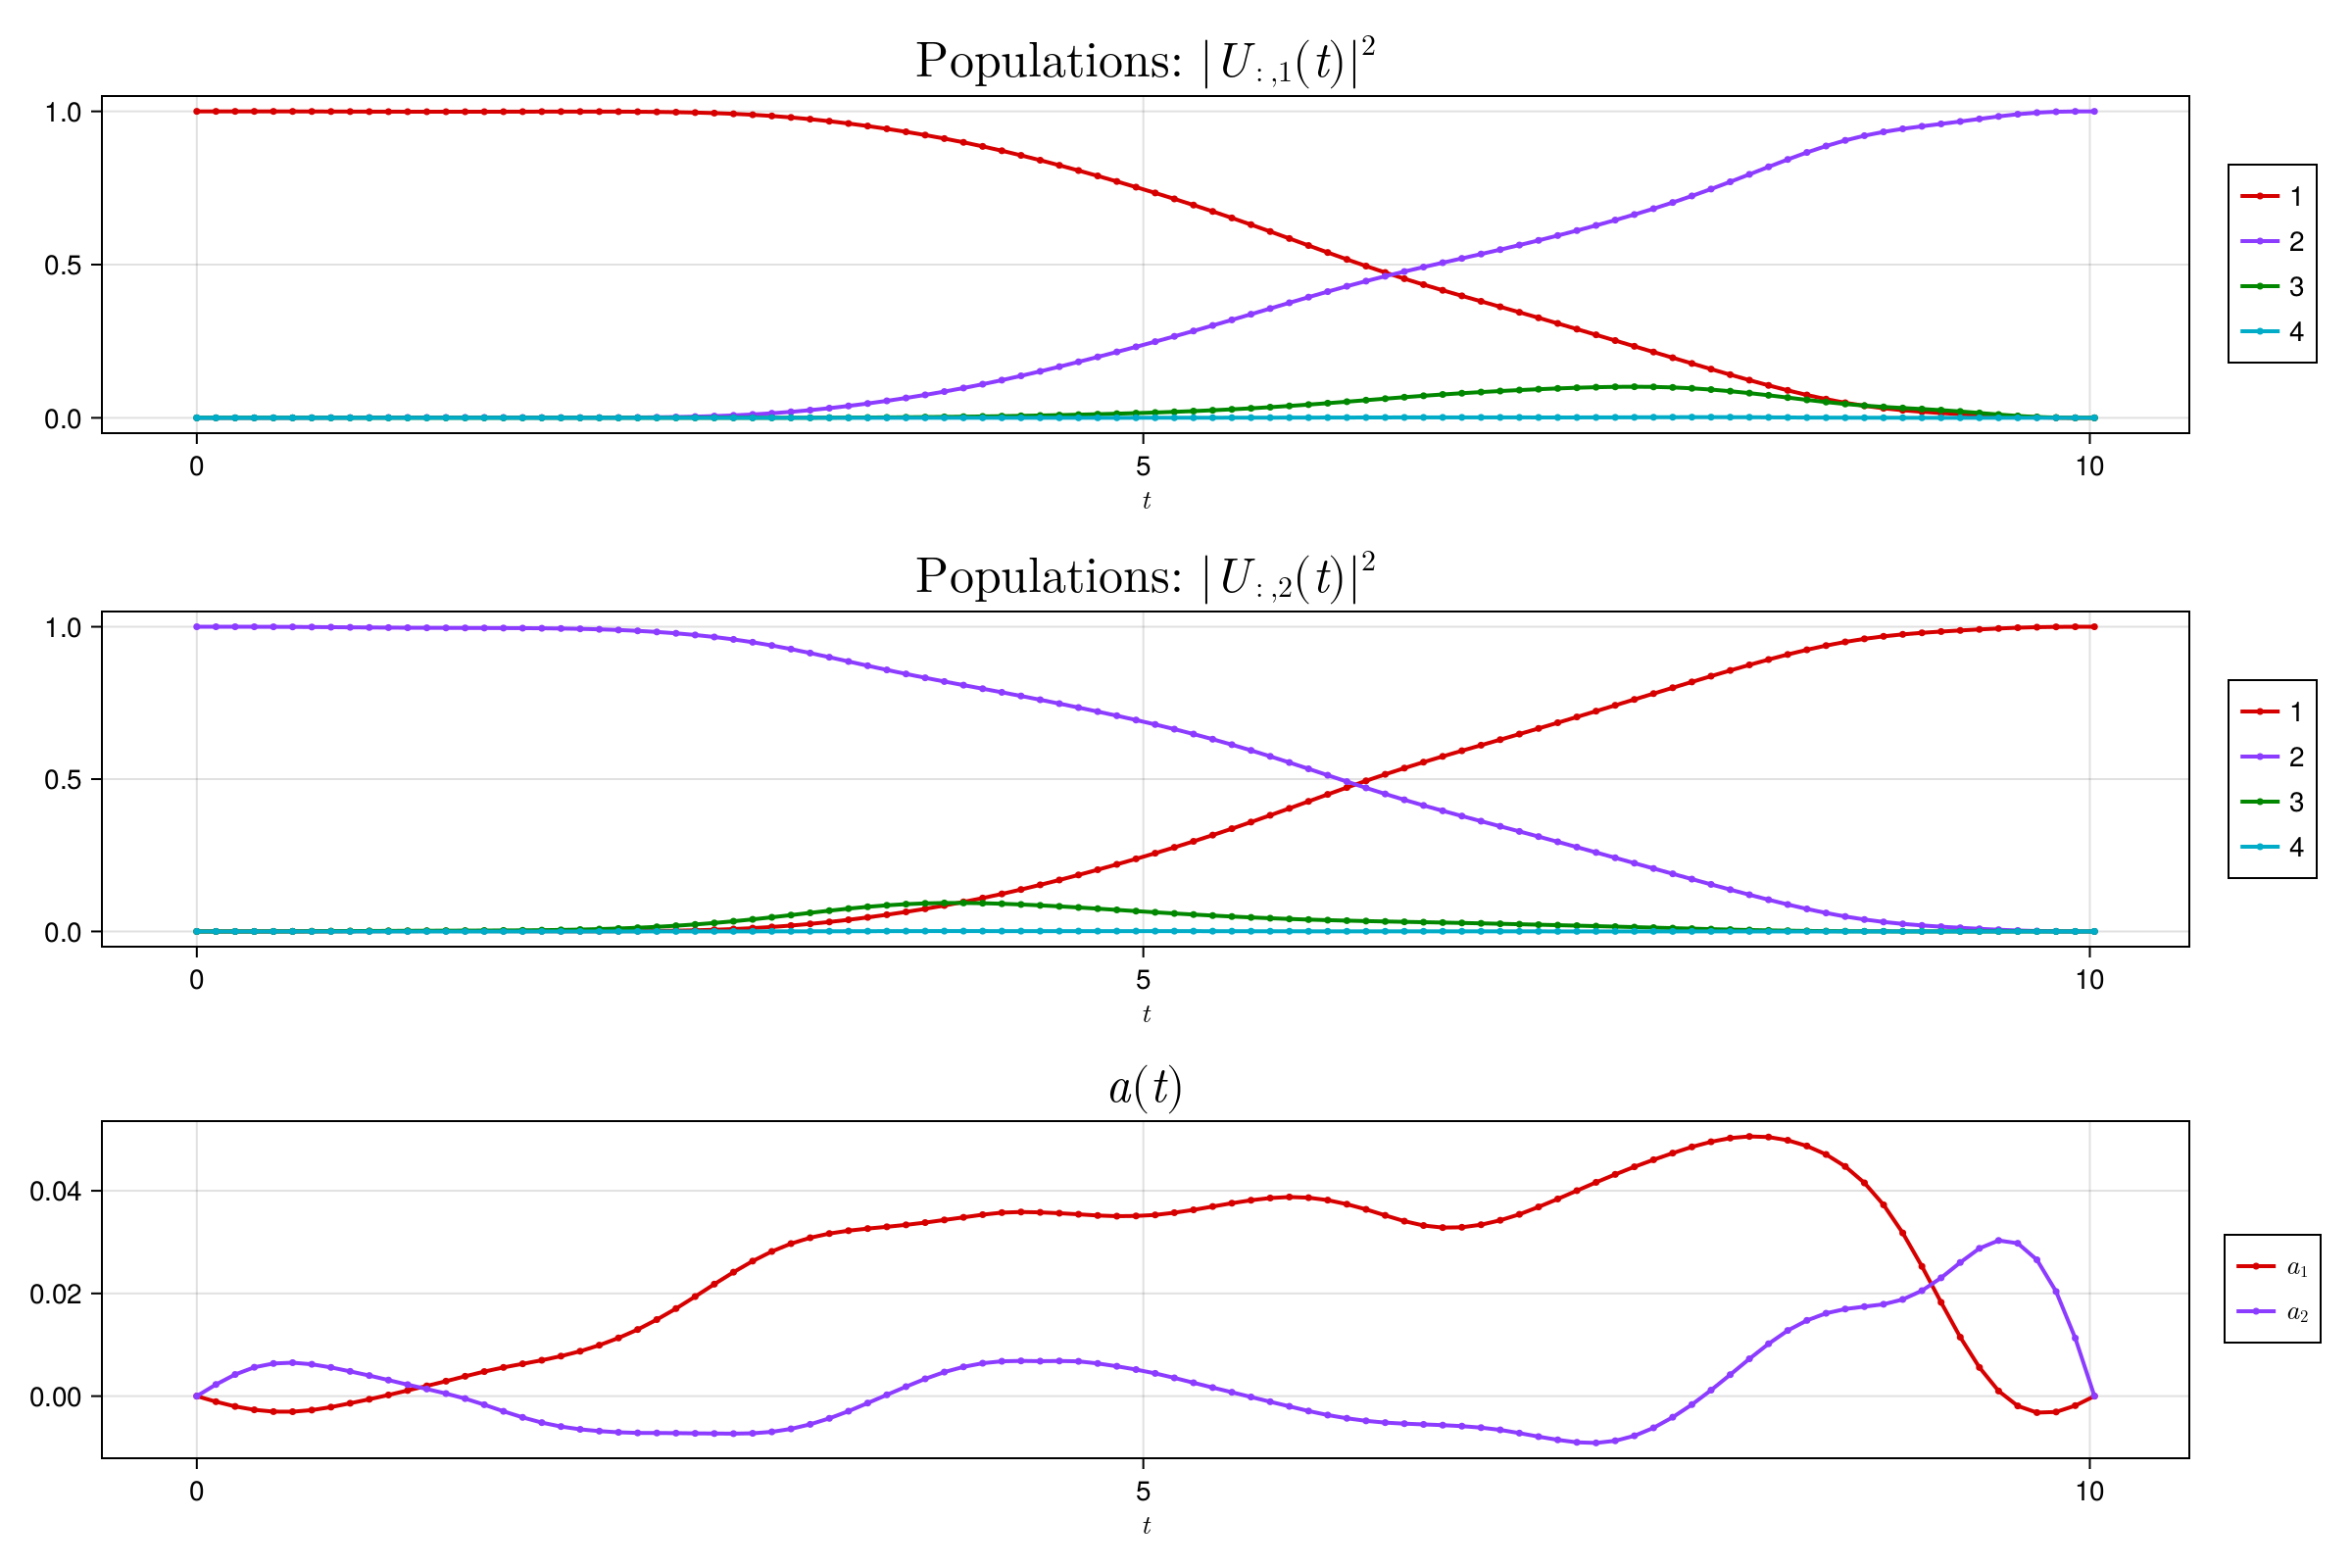

In [5]:
plot_unitary_populations(prob.trajectory; unitary_columns=1:2, res=(1000, 700))

# Minimum Time Problem

To solve a minimum time problem we will add a term of the form

$$
J_{\text{mintime}}(\Delta t) = D \sum_k \Delta t_k
$$

To the objective, as well as adding a constraint that enforces the minimum final fidelity to be at least $\mathcal{F}_{\text{min}} = 0.999$:

$$
\mathcal{F}(U_T) \geq \mathcal{F}_{\text{min}}
$$

In [6]:
prob_min_time = UnitaryMinimumTimeProblem(prob;
    final_fidelity=0.999,
    D=1e-1,
    subspace=op.subspace_indices
)

solve!(prob_min_time; max_iter=50)

println()

println("fidelity = ", unitary_fidelity(prob_min_time, subspace=op.subspace_indices)^2)

println()

original_duration = get_times(prob.trajectory)[end]
minimum_duration = get_times(prob_min_time.trajectory)[end]

println("Original duration: $(round(original_duration, digits=2)) ns")
println(" Minimum duration: $(round(minimum_duration, digits=2)) ns")
println("          Speedup: $(round(original_duration - minimum_duration, digits=2)) ns")


applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    52194
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    22066

Total number of variables............................:     3864
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3663
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality 

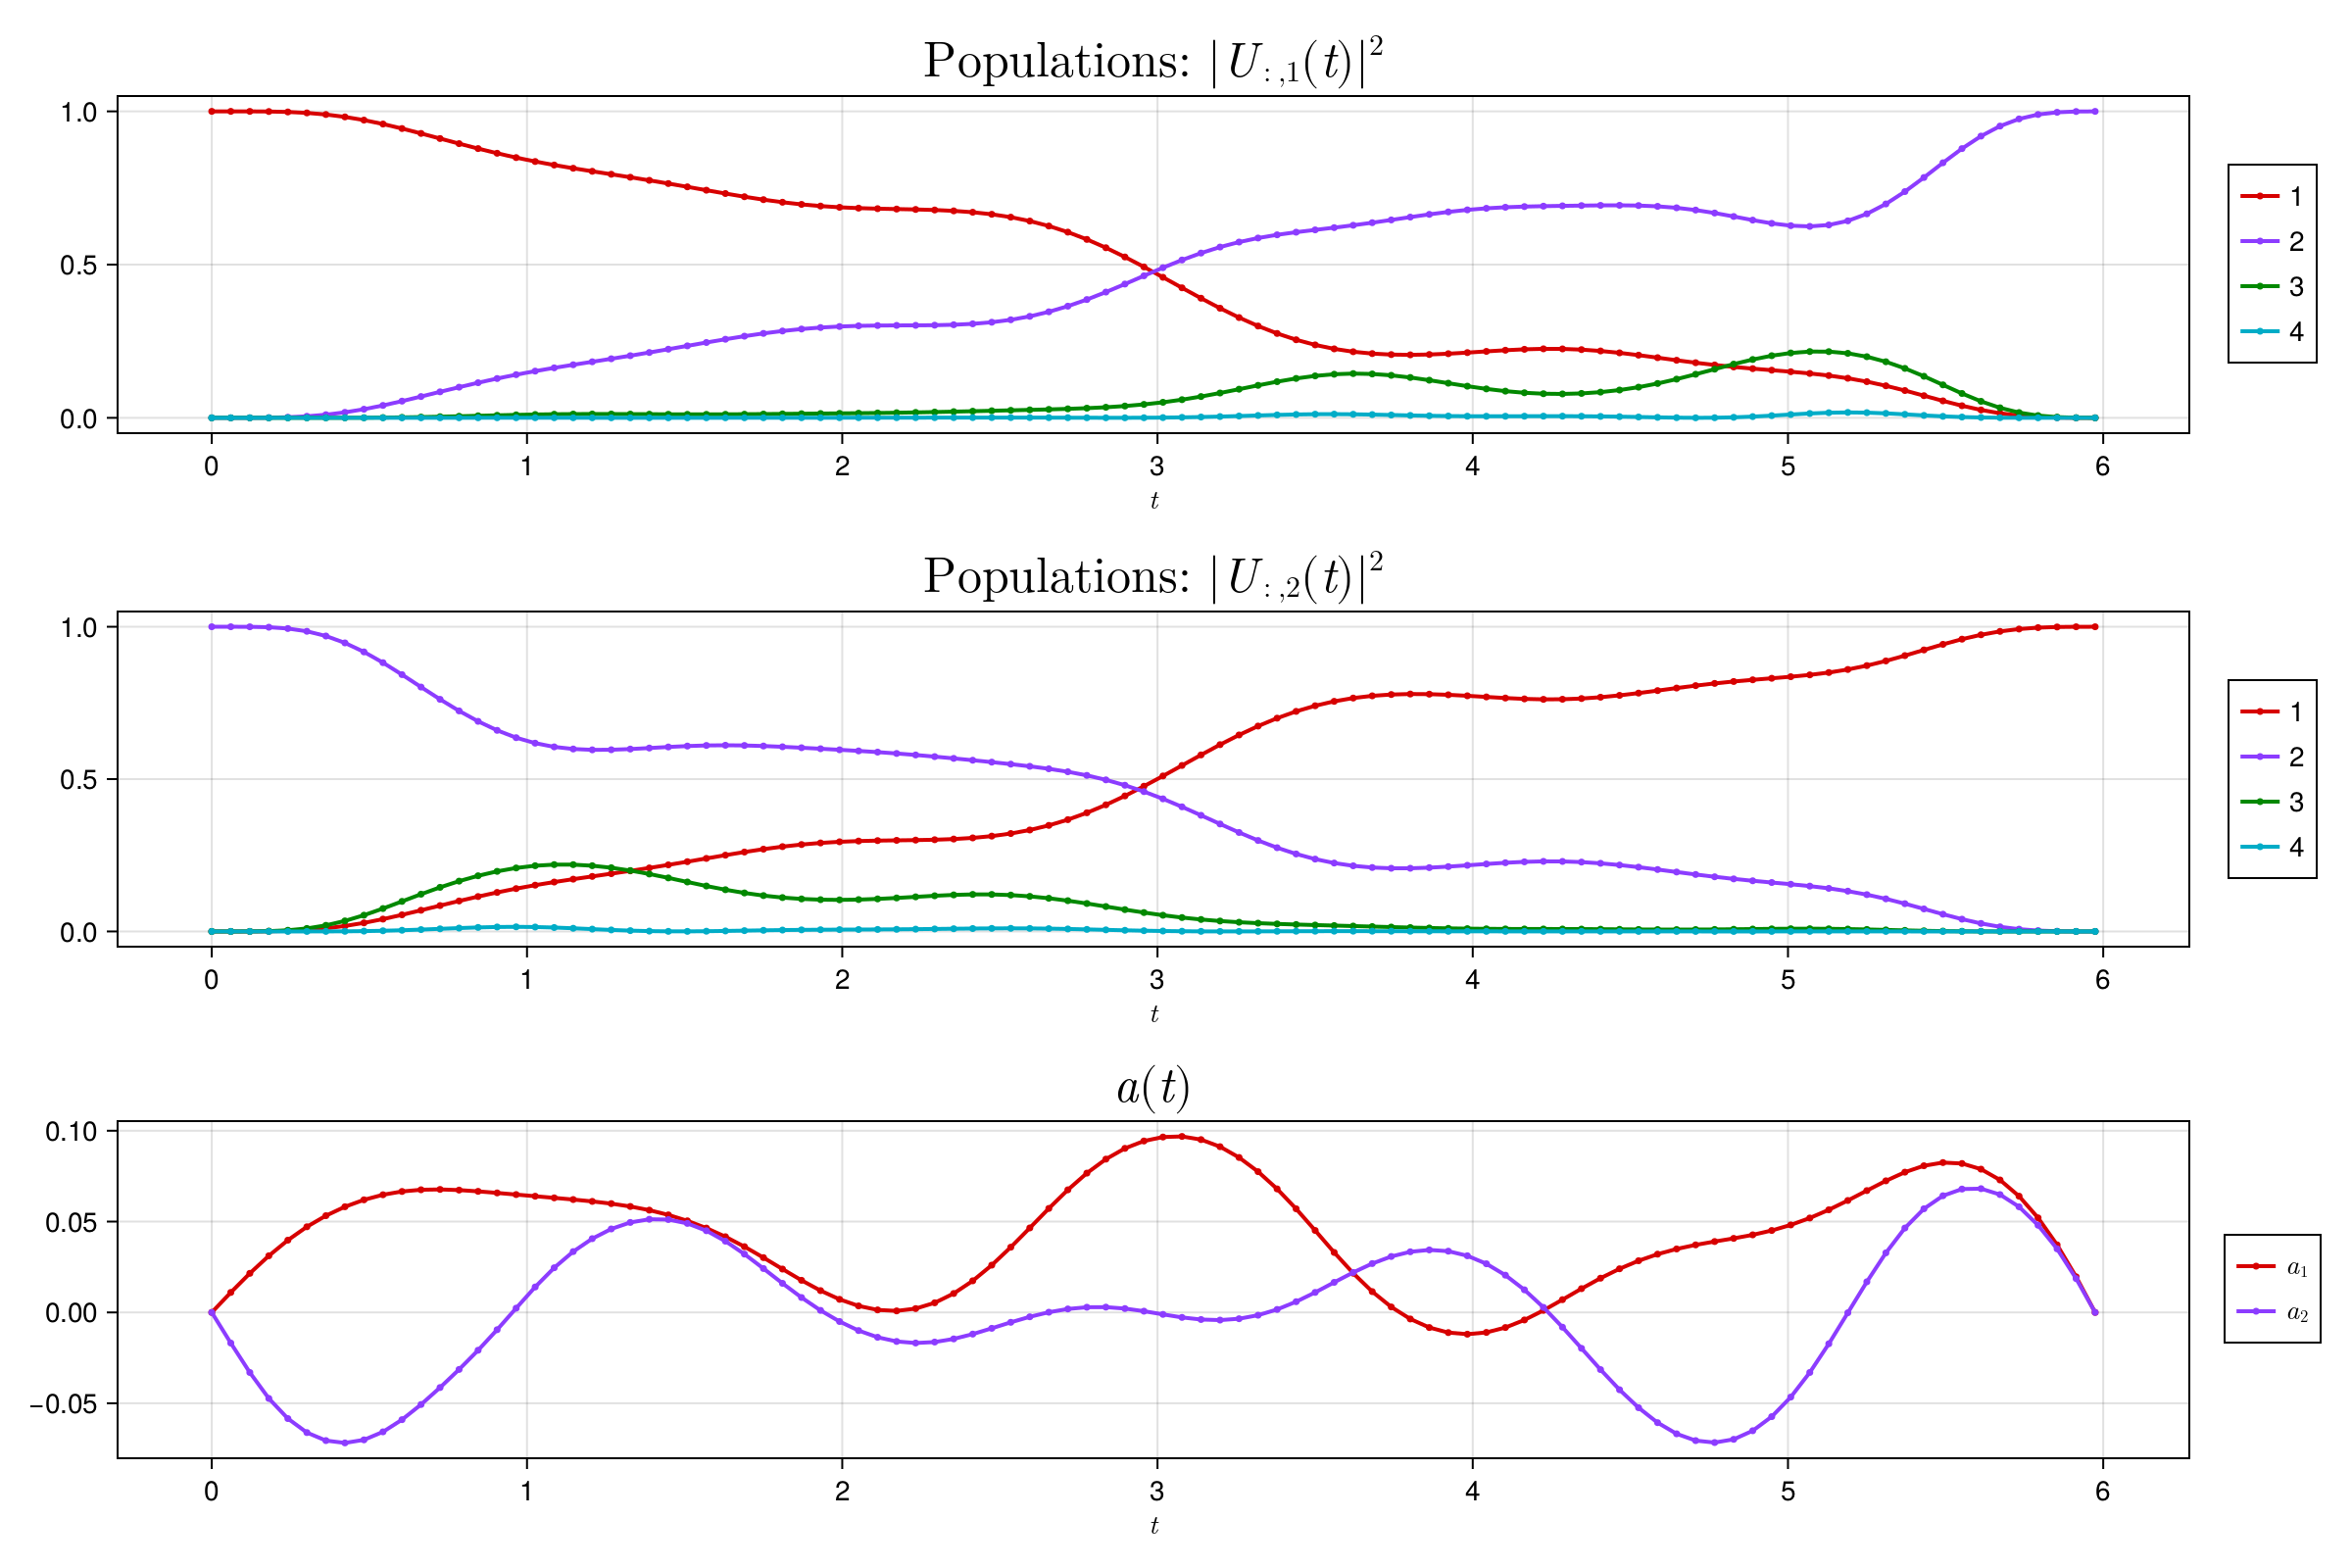

In [7]:
plot_unitary_populations(prob_min_time.trajectory; unitary_columns=1:2, res=(1000, 700))

# Leakage Suppression

We can enforce leakage suppression by adding an objective term of the form

$$
J_{\text{leakage}}(x) = \sum_{i,l} |U^{R}_{i,l}| + |U^{I}_{i,l}|
$$

This is $L_1$ norm regularizer on the real and imaginary parts of the $U_{i,l}$ unitary components, these are those components that transfer population out of the subspace into the leakage space.

In [ ]:
prob_leakage = UnitarySmoothPulseProblem(sys, op, T, dt; 
    leakage_suppression=true, 
    R_leakage=1.0e-1,
    a_bound=0.05,
    a_guess=prob.trajectory.a
)

solve!(prob_leakage; max_iter=100)

println("fidelity = ", unitary_fidelity(prob_leakage, subspace=op.subspace_indices)^2)

In [ ]:
plot_unitary_populations(prob_leakage.trajectory; unitary_columns=1:2, res=(1000, 700))

In [ ]:
plot_unitary_populations(prob.trajectory; unitary_columns=1:2, res=(1000, 700))